# Bayesian Updating

This notebook will walk through a simple example of estimating a continuous variable as a function of two categorical variables. Specifically, we will see how we can not only render an estimate, but also update the estimate as we receive more data. The key takeaway will be that despite claims to the contrary, there is no such thing as a minimum sample size. Our focus should instead be on the management of uncertainty.

In [2]:
import pymc as pm
import arviz as az
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pytensor
import pytensor.tensor as pt
import pandas as pd
import xarray as xr
from typing import Dict, List, Set, Tuple

## Problem Statement

Hat tip to [Gemini](gemini.google.com) for the problem statement. A software development team wants to estimate the build time (in minutes) for their software modules. They believe the build time is influenced by the module's size (Small or Large) and the server's load (Low or High).

### Variables

+ **Build Time (T):** *Continuous* - Measured in minutes. This is our dependent variable.
+ **Module Size (S):** *Categorical* - Small or Large.
+ **Server Load (L):** *Categorical* - Low or High.

### Goal

We want to estimate the distribution of T given S and L, which we'll denote as P(T∣S,L). Since we are rendering a bayesian estimate, we'll be estimating the parameters of a distribution. In this case, T is continuous and we'll presume a symmetric distribution. A normal distribution is common in these situations so the parameters to estimate will be the mean and standard deviation.

## Data Generating Process

Normally, we would not know the true parameters for this process, because they would be unobserved. However, since this is a contrived example, and we want to understand if we are actually getting the right answer, we will set the true parameters and see if we can recover them. Suppose initially that the module size and server load are independent, and the data generating process is defined as follows:

$$ T = \beta_0 + \beta_1 S + \beta_2 L + \epsilon $$

or equivalently

$$ T \sim N(\beta_0 + \beta_1 S + \beta_2 L, \sigma_\epsilon) $$

For our DGP, our base case is a small module with low server load and $\beta = [1, 4, 5]$. In other words, when we have a small module ($S = 0$) and low server load ($L = 0$), our build time is 1 minute on average. Large modules add 4 minutes on average, while high server load adds 5. The variance in our estimate is given by the distribution of $\epsilon$, represented directly in the first expression and via it's standard deviation ($\sigma_\epsilon$) in the second. To simulate this data, we'll leverage [PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html) and [PyMC](https://www.pymc.io/), our estimation package of choice. First, a straightforward translation of the DGP above (note that the $1$ values capture the intercept):

$$ Y = X\beta + \epsilon = \begin{bmatrix} 1 & S & L \end{bmatrix} \begin{bmatrix} 1 \\ 4 \\ 5 \end{bmatrix} + \epsilon $$

where $S$ and $L$ can both take values in $\{0, 1\}$.

Identity [id A] 'bt'
 └─ Add [id B]
    ├─ Sum{axes=None} [id C]
    │  └─ Mul [id D]
    │     ├─ Identity [id E] 'beta'
    │     │  └─ [3 4 5] [id F]
    │     └─ Identity [id G] 'data'
    │        └─ Join [id H]
    │           ├─ 0 [id I]
    │           ├─ Identity [id J] 'intercept'
    │           │  └─ Alloc [id K]
    │           │     ├─ 1.0 [id L]
    │           │     └─ 1 [id M]
    │           ├─ bernoulli_rv{"()->()"}.1 [id N] 'S'
    │           │  ├─ RNG(<Generator(PCG64) at 0x7065DA19E500>) [id O]
    │           │  ├─ NoneConst{None} [id P]
    │           │  └─ [0.2] [id Q]
    │           └─ bernoulli_rv{"()->()"}.1 [id R] 'L'
    │              ├─ RNG(<Generator(PCG64) at 0x7065DA19E880>) [id S]
    │              ├─ NoneConst{None} [id P]
    │              └─ [0.4] [id T]
    └─ normal_rv{"(),()->()"}.1 [id U] 'e'
       ├─ RNG(<Generator(PCG64) at 0x7065DA19F760>) [id V]
       ├─ NoneConst{None} [id P]
       ├─ 0 [id W]
       └─ 1.2 [id X]


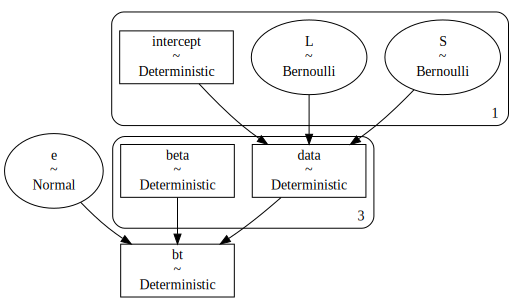

In [4]:
with pm.Model() as gen_model:
    # We are hard coding our coefficients instead of estimating them
    beta: pt.TensorConstant = pm.Deterministic("beta", pm.math.constant([3, 4, 5]))
                                              
    # Our input data includes a column of ones to accommodate the intercept
    intercept: pt.TensorConstant = pm.Deterministic("intercept", pm.math.ones(shape=(1,)))
    s: pt.TensorVariable = pm.Bernoulli(p=[0.2], name="S")
    l: pt.TensorVariable = pm.Bernoulli(p=[0.4], name="L")
    data: pt.TensorVariable = pm.Deterministic("data", pt.concatenate([intercept, s, l]))

    # The data above compute the expected value, while epsilon provides the
    # variance around that value
    e: pt.TensorVariable = pm.Normal(mu=0, sigma=1.2, name="e")

    # Our simulated output is now just arithmetic given the inputs
    bt: pt.TensorVariable = pm.Deterministic("bt", pt.sum(beta * data) + e)

pytensor.dprint(gen_model.bt)
pm.model_to_graphviz(gen_model)

Now that we have our model, we can just draw samples from it, which `pymc` makes easy. Once the samples are drawn, we can examine the distribution of module size ($S$), server load ($L$), observed build time ($bt$), and variance about the expected build time conditional on module size and server load ($e$). Note how the categorical distributions, $S$ and $L$, differ from the continuous distributions $bt$ and $e$.

Sampling: [L, S, e]
/home/choct155/tools/miniconda3/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'e'}>, <Axes: title={'center': 'bt'}>,
        <Axes: title={'center': 'data\n0'}>],
       [<Axes: title={'center': 'data\n1'}>,
        <Axes: title={'center': 'data\n2'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'intercept\n0'}>],
       [<Axes: title={'center': 'L\n0'}>,
        <Axes: title={'center': 'S\n0'}>, <Axes: >]], dtype=object)

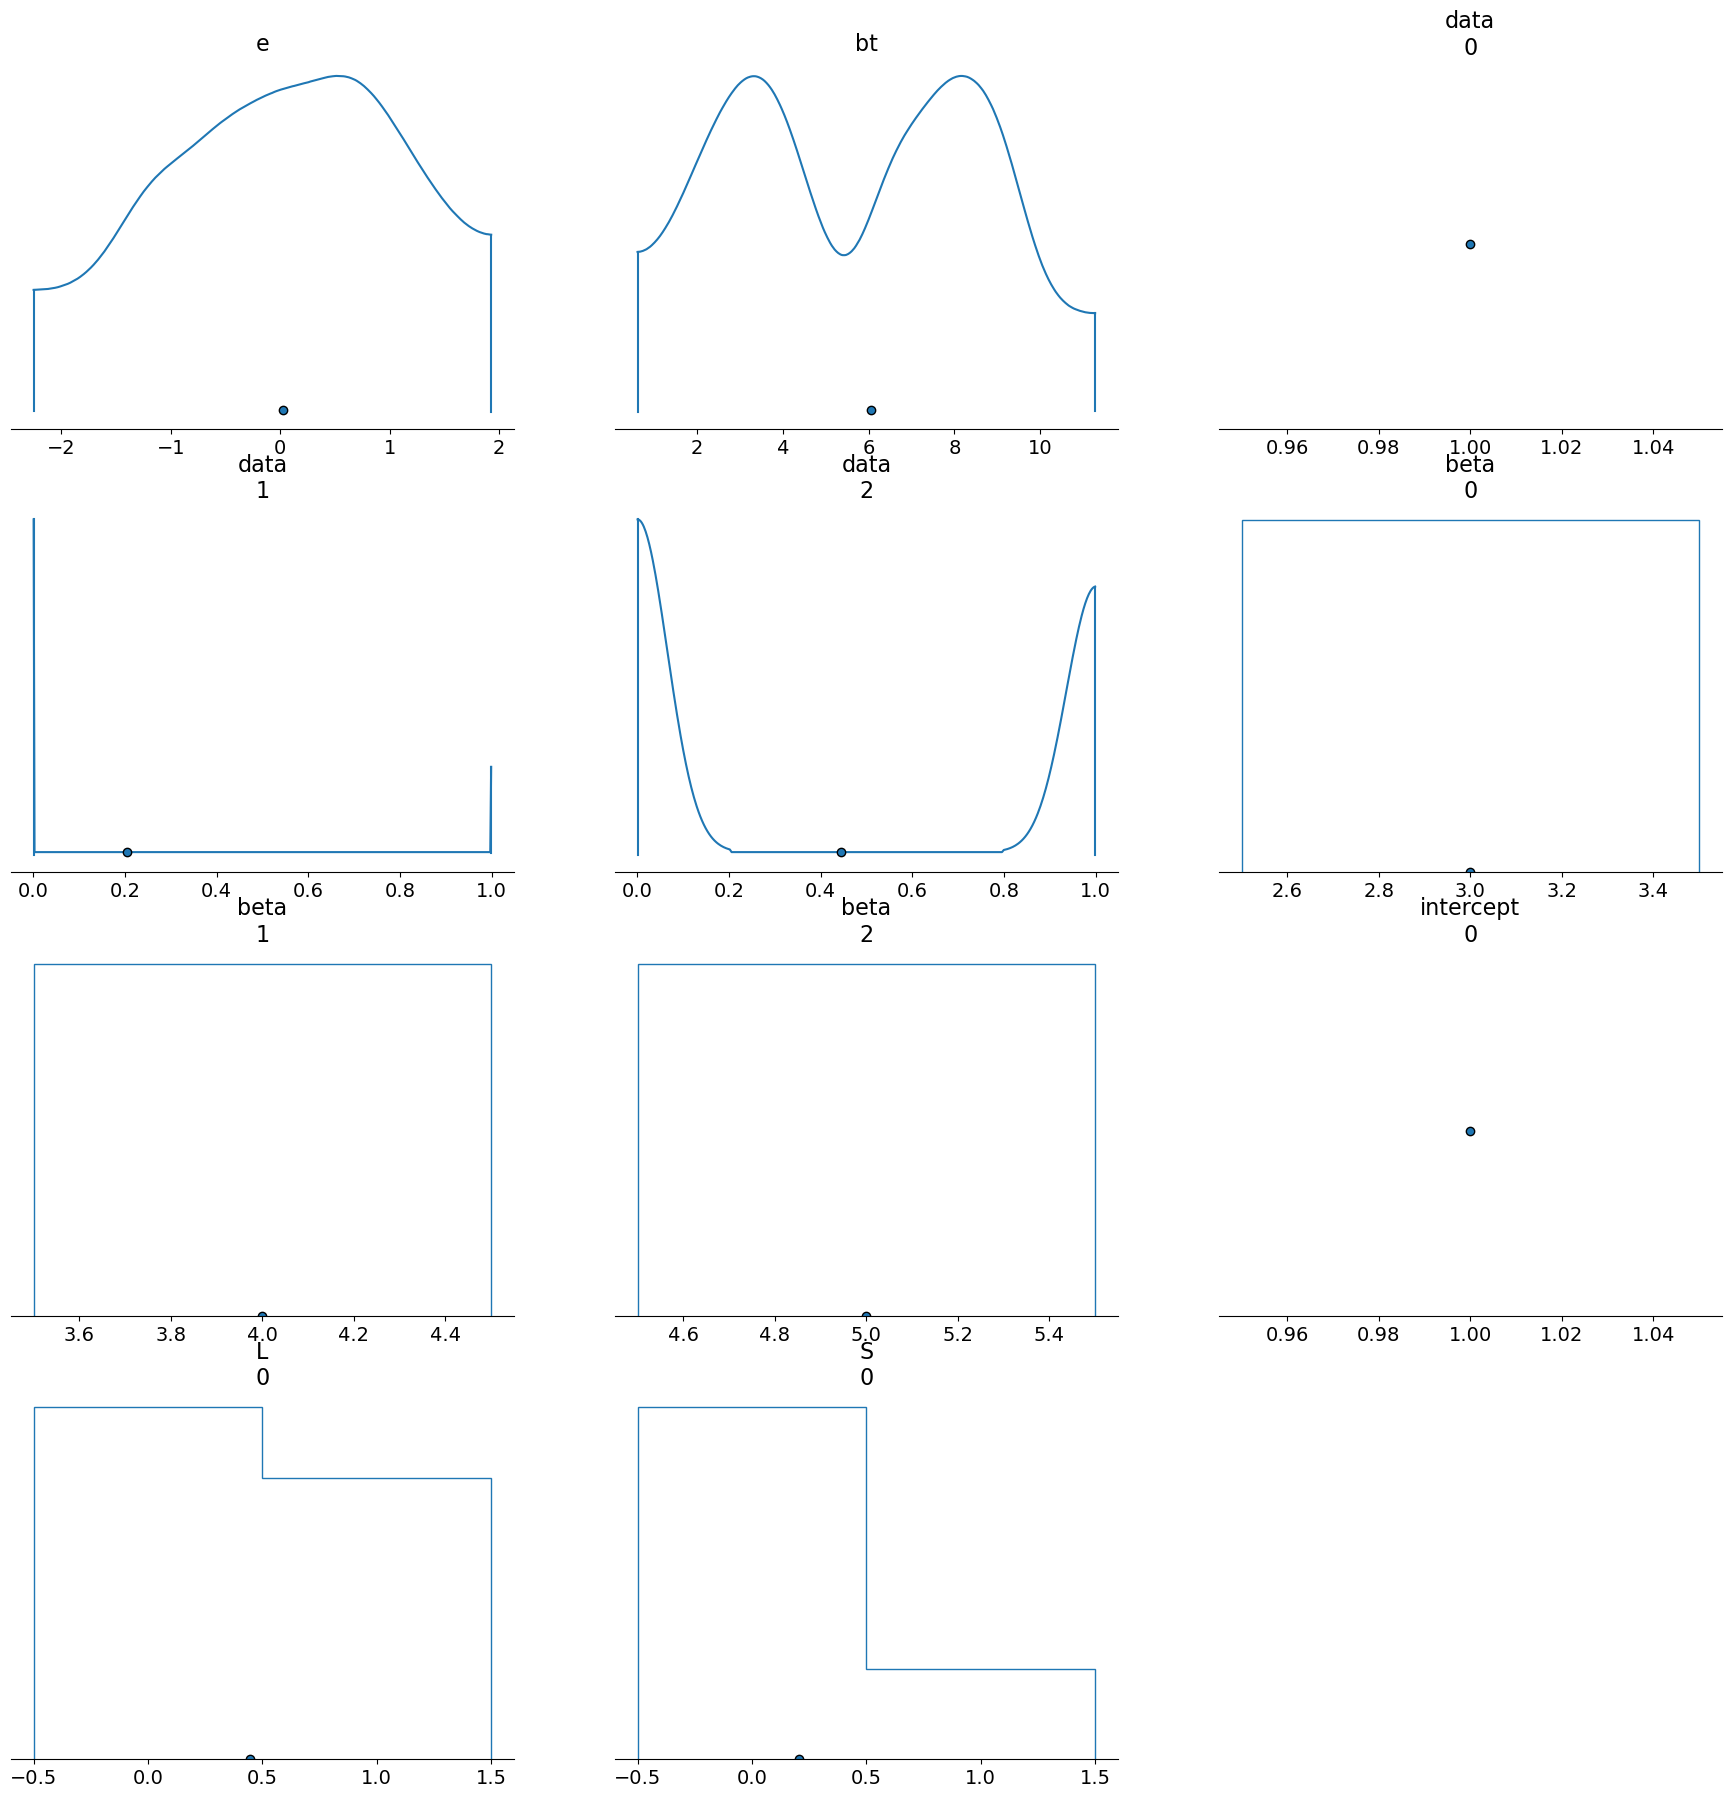

In [3]:
data: az.InferenceData = pm.sample_prior_predictive(draws=500, model=gen_model)
az.plot_density(data["prior"])

## Estimation

So, what did we just do? We made claims about states of the world ($H$) and then generated data ($D$) that was consistent with those claims. In other words, we constructed the sampling distribution $P(D|H)$. However, as we said earlier, that's a bit backwards. We typically don't know what the state of the world is, but we can observe data. The state of the world, $P(H|D)$, is what we want to figure out. Which $H$ is the correct one? You can imagine going through a bunch of $H$ values (i.e. $P(D_0|H_0), P(D_1|H_1), P(D_2|H_2), ..., P(D_n|H_n)$ ) to try to figure out which claim, $H_i$, produces data, $D_i$, that is most consistent with the data we observe, $D$. The $H_i$ that minimizes the distance between $D_i$ and $D$ is the $H_i$ that is most consistent with the data, and therefore our most informed guess of $H$. (Given a uniform prior or enough data, the appropriately selected $H_i$ would converge with the [maximum likelihood estimate](https://youtu.be/YevSE6bRhTo?si=G_JsnNs3gpRDOsop) of $H$.)

In our case, $H$ is a vector of values $\beta = [\beta_0, \beta_1, \beta_2]$:
+ $\beta_0$ is the average build time for small modules with low server load (i.e. the base case)
+ $\beta_1$ is the additional build time for large modules, relative to the base case
+ $\beta_2$ is the additional build time for large server loads, relative to the base case

Finding the right $H$ value amounts to finding the value of $\beta$ that most likely generated the data we saw. If that's our objective, what procedure can we use to identify the right $H$? The key insight is the right value of $H$ is the one for which the probability is highest having observed the data. In other words, $\text{max }P(H|D)$ is our best guess. To identify that value, we want to know the probability associated with all values of $H$ (or at least many of them) so we can compare the probabilities and determine the maximum. That is, we want the distribution of probabilities across different values of $H$, which is captured by the distribution $P(H|D)$. Sounds very reasonable, but about that procedure...

### Enter Bayes' Rule

$$ P(H|D) = \frac{P(D|H) P(H)}{P(D)} $$

Bayes rule sounds like a fancy thing that must be memorized, but it's kind of just a logical thing. To simplify our example only a bit, imagine we had two events we were observing: build time and module size. If I have a data set, I would see tuples of observations $[(bt_1, S_1), (bt_2, S_2), \dots, (bt_n, S_n)]$. In a dataframe, these tuples are just the values in each row.

In [4]:
joint_sub: pd.DataFrame = data["prior"][["bt", "S"]].to_dataframe().droplevel(["chain", "S_dim_0"])

joint_sub[:10]

,bt,S
draw,,
0,6.372661,1
1,1.208066,0
2,12.634299,1
3,12.486320,1
4,7.569735,1
5,7.344529,0
6,2.351453,0
7,6.952281,0
8,6.434311,1


This is our *joint probability distribution* of $bt$ and $S$, a.k.a. $P(bt, S)$. Each individual row is a dual-valued draw from our DGP. This idea scales to 3, 4, or $n$ values in each draw if we want. The key is that we observe all of those values together. At any point, we can break this joint distribution down into separate probability distributions. 

$$ P(bt, S) = P(S)P(bt|S) $$

The joint distribution of $bt$ and $S$ is just the probability that we observe a given value of $S$ multiplied by the probability of observing a given value of $bt$ on the subset of data that correspond to that state of $S$.

$$ 
\begin{align}
P(bt=x, S=0) &= P(S=0)P(bt=x|S=0) \\
P(bt=x, S=1) &= P(S=1)P(bt=x|S=1) 
\end{align}
$$

$P(S)$ is just the proportion of times we observe 0 or 1 since it is a binary variable, and $P(bt|S)$ is the probability distribution of $bt$ for the subset of data for which $S$ is 0 or 1. All we are saying with the conditional probability is, if I observe a large module, I am already in a specific part of the distribution of build times. I can isolate my view to that part of the distribution, which may be different than the build times I see elsewhere, like when modules are small. If I weight that distribution by how often I see it ($P(S)$), I can reason about the frequency with which I observe specific pairs of values. This is easy to see when we plot the data. I am more likely to see longer build times when the module is large.

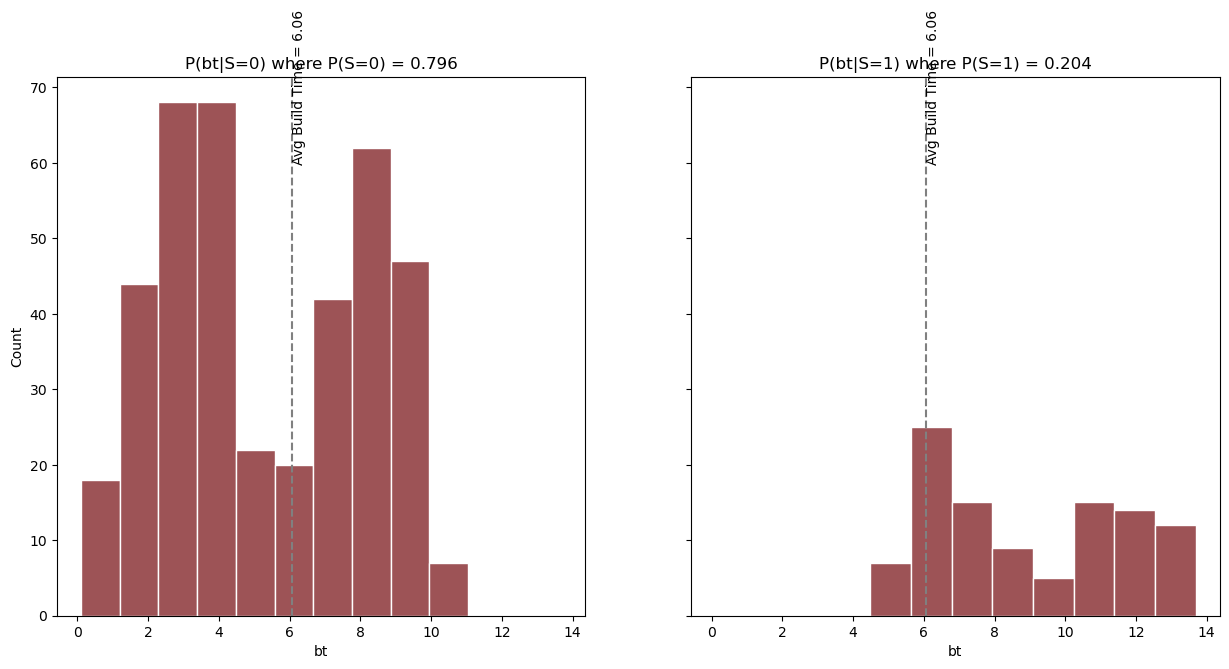

In [5]:
ps0: float = len(joint_sub[joint_sub["S"] == 0]) / float(len(joint_sub))
ps1: float = len(joint_sub[joint_sub["S"] == 1]) / float(len(joint_sub))
bt_s0: pd.DataFrame = joint_sub[joint_sub["S"] == 0]["bt"]
bt_s1: pd.DataFrame = joint_sub[joint_sub["S"] == 1]["bt"]

def plot_hist(data_in: np.array, title: str, ax: plt.Axes) -> plt.Figure:
    sb.histplot(data_in, ax=ax, color="#7d191e", ec="w")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
plot_hist(data_in=bt_s0, title=f"P(bt|S=0) where P(S=0) = {ps0}", ax=ax[0])
plot_hist(data_in=bt_s1, title=f"P(bt|S=1) where P(S=1) = {ps1}", ax=ax[1])
for a in ax:
    bt_mu:float = joint_sub["bt"].mean()
    a.axvline(x=bt_mu, linestyle="--", color="grey")
    a.annotate(f"Avg Build Time = {round(bt_mu, 2)}", xy=(bt_mu, 70), rotation=90, va="center")

You can think of $P(S)$ as a kind of weight. If we wanted to recover the overall average build time, we can compute it directly as a weighted average of conditional distributions.

$$ 
P(bt=x) = P(S=0)P(bt=x|S=0) + P(S=1)P(bt=x|S=1) 
$$

In [6]:
expected_bt: float = ps0 * bt_s0.mean() + ps1 * bt_s1.mean()
expected_bt

np.float64(6.062964912035441)

Critically, there is no reason we have to break down this joint distribution in only one way.

$$ P(bt, S) = P(S)P(bt|S) = P(bt)(P(S|bt) $$

We are free to decompose it in either direction, which is what gives us a lot of flexibility. Now we can choose what we want to compute based upon what we can observe. If we want to estimate which module size we are observing based upon build times...

$$ P(S|bt) = \frac{P(bt|S)P(S)}{P(bt)} $$

... and if we want to estimate build times based upon the observed module size:

$$ P(bt|S) = \frac{P(S|bt)P(bt)}{P(S)} $$

### Building a Model for Estimation

Now that we know how to generate the conditional probability distribution of interest, let's get back to estimation. In our case...

$$ P(H|D) = \frac{P(D|H) P(H)}{P(D)} $$

...translates to the following:

$$ P(\beta|bt) = \frac{P(bt|\beta) P(\beta)}{P(bt)} $$

You are probably tired of hearing this, but we don't know $\beta$ because that is what we are trying to estimate. However, we probably wouldn't argue that all values are equally probable - $2^{32}$ and $-100$ are probably unlikely. We can express these expectations as a prior distribution on $\beta$. Once we have our priors, we can use them to generate a prior predictive sample.

/home/choct155/tools/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [b_0, b_l, b_s, bt_est, sigma]


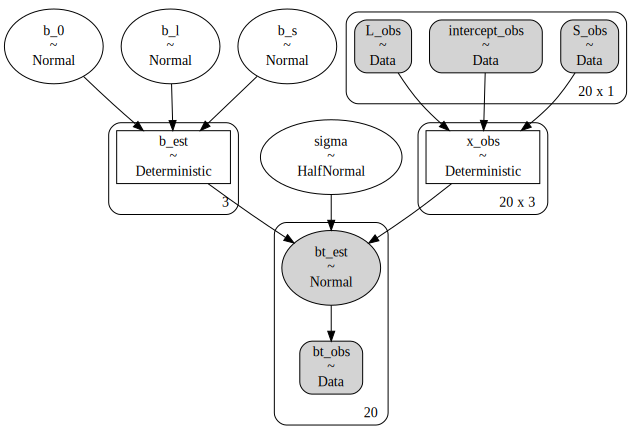

In [7]:
data_dict: Dict[str, np.array] = dict([(c, data["prior"][c].values.T) if c == "bt" else (c, np.squeeze(data["prior"][c].values, axis=0)) for c in ["bt", "S", "L", "intercept"]])

obs_increment: int = 20
num_updates: int = 10
obs_chunks: List[Tuple[int, int]] = [(i*obs_increment, (i+1)*obs_increment) for i in range(num_updates)]

with pm.Model() as est_model:
    # Now we are estimating our coefficients, so we need priors
    beta_0: pt.TensorVariable = pm.Normal(mu=1, sigma=1, name="b_0")
    beta_1: pt.TensorVariable = pm.Normal(mu=3, sigma=2, name="b_s")
    beta_2: pt.TensorVariable = pm.Normal(mu=10, sigma=6, name="b_l")
    b_est: pt.TensorVariable = pm.Deterministic("b_est", pt.stack([beta_0, beta_1, beta_2]))
    sigma: pt.TensorVariable = pm.HalfNormal(sigma=1.2, name="sigma")

    # Now we are using actual observed data 
    start, end = obs_chunks[0]
    bt_obs: pm.Data = pm.MutableData("bt_obs", data_dict["bt"][start:end].flatten())
    s_obs: pm.Data = pm.MutableData("S_obs", data_dict["S"][start:end])
    l_obs: pm.Data = pm.MutableData("L_obs", data_dict["L"][start:end])
    intercept_obs: pm.Data = pm.MutableData("intercept_obs", data_dict["intercept"][start:end])
    x_data: pt.TensorVariable = pm.Deterministic("x_obs", pt.concatenate([intercept_obs, s_obs, l_obs],axis=1))

    # Estimate the model based upon observed data
    mu: pt.TensorVariable = pm.math.dot(x_data, b_est)
    bt_est: pt.TensorVariable = pm.Normal("bt_est", mu=mu, sigma=sigma, observed=bt_obs)

    est_trace: xr.Dataset = pm.sample(1000)

est_prior: az.InferenceData = pm.sample_prior_predictive(draws=1000, model=est_model)
pm.model_to_graphviz(est_model)

Now we can inspect the shift in our parameter distributions, from the priors we set to the posterior distributions after exposure to data.

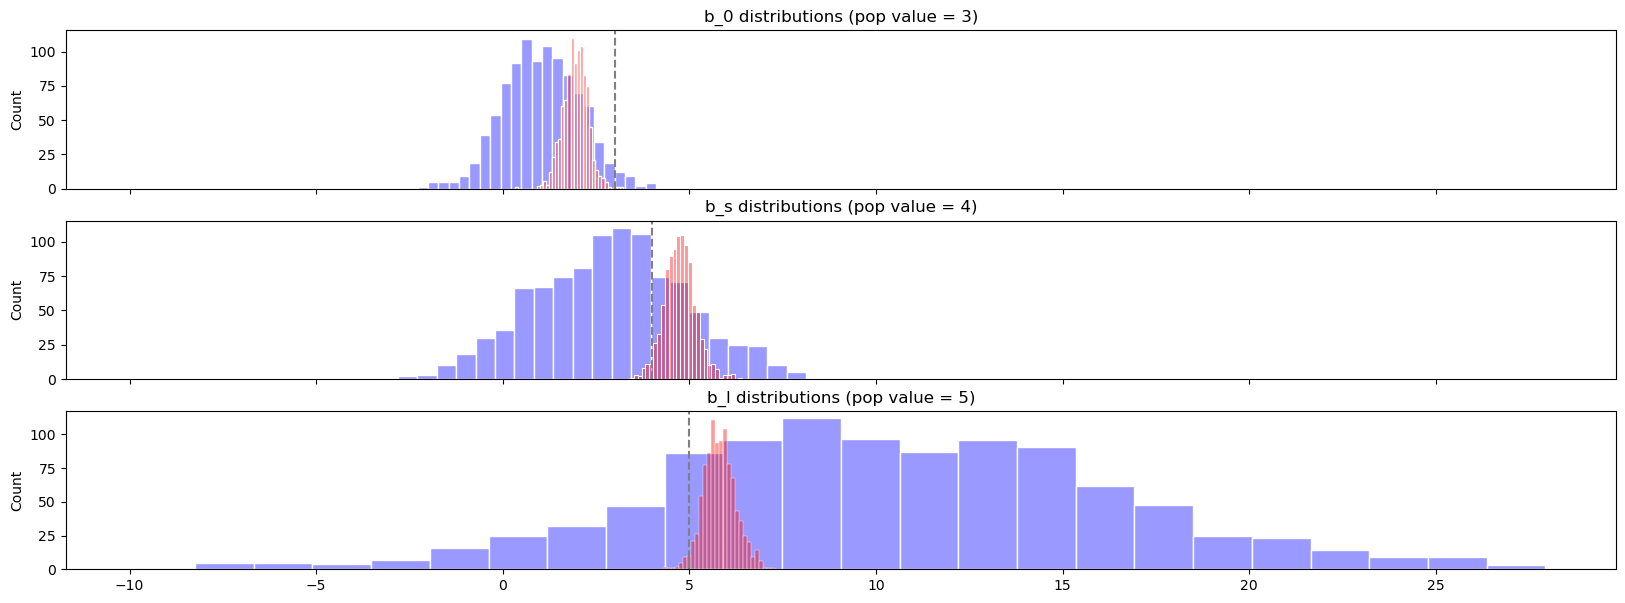

In [8]:
dists: Dict[str, Dict[str, np.array]] = {
    "b_0": {
        "pop_value": np.array([data.prior.beta.values[0][0][0]]),
        "prior_dist": est_prior.prior.b_0.values[0],
        "post_dist": est_trace.posterior.b_0.values[0]
    },
    "b_s": {
        "pop_value": np.array([data.prior.beta.values[0][0][1]]),
        "prior_dist": est_prior.prior.b_s.values[0],
        "post_dist": est_trace.posterior.b_s.values[0]
    },
    "b_l": {
        "pop_value": np.array([data.prior.beta.values[0][0][2]]),
        "prior_dist": est_prior.prior.b_l.values[0],
        "post_dist": est_trace.posterior.b_l.values[0]
    }
}
        
def dist_compare(coeff: str, ax: plt.Axes, dist_dict: Dict[str, Dict[str, np.array]] = dists) -> plt.Axes:
    pop_value: float = dist_dict[coeff]["pop_value"][0]
    prior_dist: np.array = dist_dict[coeff]["prior_dist"]
    post_dist: np.array = dist_dict[coeff]["post_dist"]
    sb.histplot(prior_dist, color="blue", label="prior", ax=ax, alpha=0.4, ec="white")
    sb.histplot(post_dist, color="red", label="posterior", ax=ax, alpha=0.4, ec="white")
    ax.axvline(x=pop_value, linestyle="--", color="grey")
    ax.set_title(f"{coeff} distributions (pop value = {pop_value})")

fig, ax = plt.subplots(3, figsize=(20, 7), sharex=True)
for i, c in enumerate(["b_0", "b_s", "b_l"]):
    dist_compare(c, ax[i])

Ok, let's gut check this. If we were to hold out the next chunk of observations, we can compare actual observations of build time with the estimates generated from the expected value of our parameters (based upon the posterior distributions). Are they close?

Sampling: [bt_est]


Output()

Mean Squared Error: <xarray.DataArray 'bt_est' ()> Size: 8B
array(1.65896739)
Mean Absolute Error: <xarray.DataArray 'bt_est' ()> Size: 8B
array(1.06500257)


Text(0, 0.5, 'Residuals')

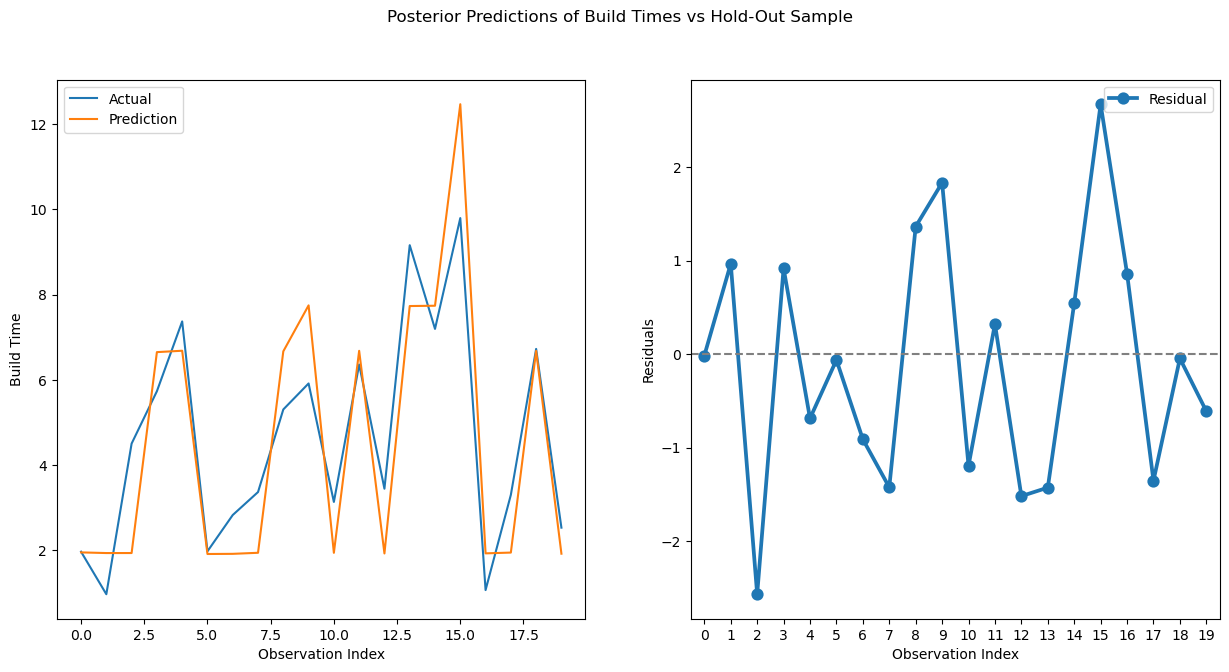

In [9]:
# Select the next chunk as the hold-out sample
hold_out_start, hold_out_end = obs_chunks[1]  # Use the second chunk as the hold-out sample
hold_out_actual: np.array = data_dict["bt"][hold_out_start:hold_out_end].flatten()

# Update the model with the hold-out sample
est_model.set_data(name="bt_obs", values=hold_out_actual)
est_model.set_data(name="S_obs", values=data_dict["S"][hold_out_start:hold_out_end])
est_model.set_data(name="L_obs", values=data_dict["L"][hold_out_start:hold_out_end])
est_model.set_data(name="intercept_obs", values=data_dict["intercept"][hold_out_start:hold_out_end])

# Generate posterior predictive samples
with est_model:
    posterior_predictive: xr.Dataset = pm.sample_posterior_predictive(est_trace, var_names=["bt_est"])

# Extract predictions
hold_out_predictions: np.array = posterior_predictive.posterior_predictive["bt_est"].mean(axis=0).mean(axis=0)
diff: np.array = hold_out_predictions - hold_out_actual

# Compute evaluation metrics
mse: float = np.mean((hold_out_predictions - hold_out_actual) ** 2)
mae: float = np.mean(np.abs(hold_out_predictions - hold_out_actual))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Optional: Visualize predictions vs actual values
fig, ax = plt.subplots(1, 2, figsize=(15,7))
compare_actual: plt.Axes = sb.lineplot(x=range(len(hold_out_actual)), y=hold_out_actual, label="Actual", ax=ax[0])
compare_predict: plt.Axes = sb.lineplot(x=range(len(hold_out_actual)), y=hold_out_predictions, label="Prediction", ax=ax[0])
predict_less_actual: plt.Axes = sb.pointplot(x=range(len(hold_out_actual)), y=diff, label="Residual", ax=ax[1])
ax[1].axhline(y=0, linestyle="--", color="grey")
plt.suptitle("Posterior Predictions of Build Times vs Hold-Out Sample")
ax[0].set_xlabel("Observation Index")
ax[0].set_ylabel("Build Time")
ax[1].set_xlabel("Observation Index")
ax[1].set_ylabel("Residuals")

In [10]:
est_model.basic_RVs

[b_0 ~ Normal(1, 1),
 b_s ~ Normal(3, 2),
 b_l ~ Normal(10, 6),
 sigma ~ HalfNormal(0, 1.2),
 bt_est ~ Normal(f(b_l, b_s, b_0), sigma)]

In [11]:
posteriors_by_chunk: List[Tuple[Tuple[int, int], xr.Dataset]] = []

for chunk in obs_chunks:
    start, end = chunk
    print(f"Fitting model with observations {start} through {end}")
    est_model.set_data(name="intercept_obs", values=data_dict["intercept"][start:end])
    est_model.set_data(name="bt_obs", values=data_dict["bt"][start:end].flatten())
    est_model.set_data(name="S_obs", values=data_dict["S"][start:end])
    est_model.set_data(name="L_obs", values=data_dict["L"][start:end])

    with est_model:
        if len(posteriors_by_chunk) > 0:
            (start, end), last_trace = posteriors_by_chunk[-1]
            for var in est_model.basic_RVs[:-1]:
                if var in last_trace.posterior:
                    print(f"Updating {var} with last trace ({start}, {end})")
                    last_mu: float = last_trace.posterior[var].mean()
                    last_sigma: float = last_trace.posterior[var].std()
                    est_model[var]: pt.TensorVariable = pm.Normal(var, mu=last_mu, sigma=last_sigma)
        else:
            print("Using initial priors")
        next_trace: xr.Dataset = pm.sample(1000)
        posteriors_by_chunk.append(((start, end), next_trace))

Fitting model with observations 0 through 20
Using initial priors


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 20 through 40


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 40 through 60


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 60 through 80


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 80 through 100


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 100 through 120


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 120 through 140


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 140 through 160


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 160 through 180


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


Fitting model with observations 180 through 200


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_0, b_s, b_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [17]:
for i in range(10):
    print(posteriors_by_chunk[i][1].posterior.b_s.values.mean())

4.7367175250864735
3.5505608523040975
3.47207329184409
4.001121353348539
4.465180379825427
4.272954629008703
3.7373985843163613
4.666044741014001
3.1499875136911704
2.4820406458594344
